Implementation of AlexNet on a Dogs and Cats dataset

In [1]:
import tensorflow_datasets as tfds

Loading the dataset

In [2]:
(train_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.SJGDRF_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

This is a tensorflow dataset and not a numpy arrays.

In [4]:
len(train_dataset), len(test_dataset)

(18610, 4652)

There are 18610 train set images and 4652 test set images

In [5]:
for X, y in train_dataset:
  print(X.shape, y.numpy())
  image_1 = X.numpy()
  break

(262, 350, 3) 1


For the first image: X is (262, 350, 3) and the label y is 1 which denotes that the image is a dog.

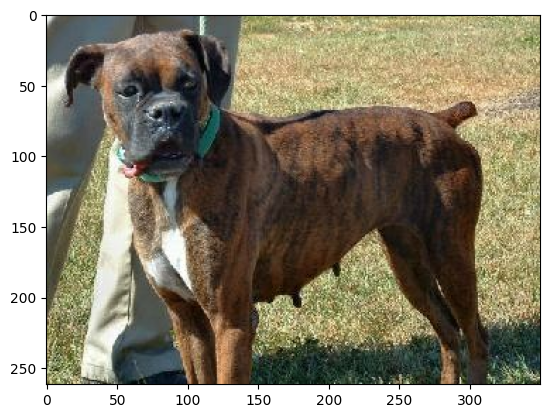

In [6]:
import matplotlib.pyplot as plt
plt.imshow(image_1)

In [7]:
import tensorflow as tf

def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

def resize(image, label):
  return (tf.image.resize(image, (224, 224)), label)

The normalize function divides each value by 255. The resize function resizes the images to a 224 by 224 image. These functions have been made so we can map them.

In [8]:
train_dataset = train_dataset.map(resize, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)

we (lazily) mapped the two functions. the two lines basically says to resize and normalise all the images.

In [9]:
SHUFFLE_VAL = len(train_dataset) // 1000
BATCH_SIZE = 4

train_dataset = train_dataset.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
test_dataset = test_dataset.map(resize, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

A pipeline for train and test images ^^

In [11]:
for (img, label) in train_dataset:
  print(img.numpy().shape)
  break

(4, 224, 224, 3)


Model Training begins here

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [13]:
def AlexNet():
  inp = layers.Input((224, 224, 3))
  x = layers.Conv2D(96, 11, strides = 4, activation = 'relu')(inp)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D(3, strides = 2)(x)
  x = layers.Conv2D(256, 5, 1, activation = 'relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D(3, strides = 2)(x)
  x = layers.Conv2D(384, 3, 1, activation='relu')(x)
  x = layers.Conv2D(384, 3, 1, activation='relu')(x)
  x = layers.Conv2D(256, 3, 1, activation='relu')(x)
  x = layers.MaxPool2D(3, 2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inp, x)
  return model

model = AlexNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,586,689 (82.35 MB)

 Trainable params: 21,585,985 (82.34 MB)

 Non-trainable params: 704 (2.75 KB)

Batch Normalisation does not exist in the original AlexNet but it improves the AlexNet model. We also used a sigmoid function instead of a 1000-softmax since we just classifying 2 classes.

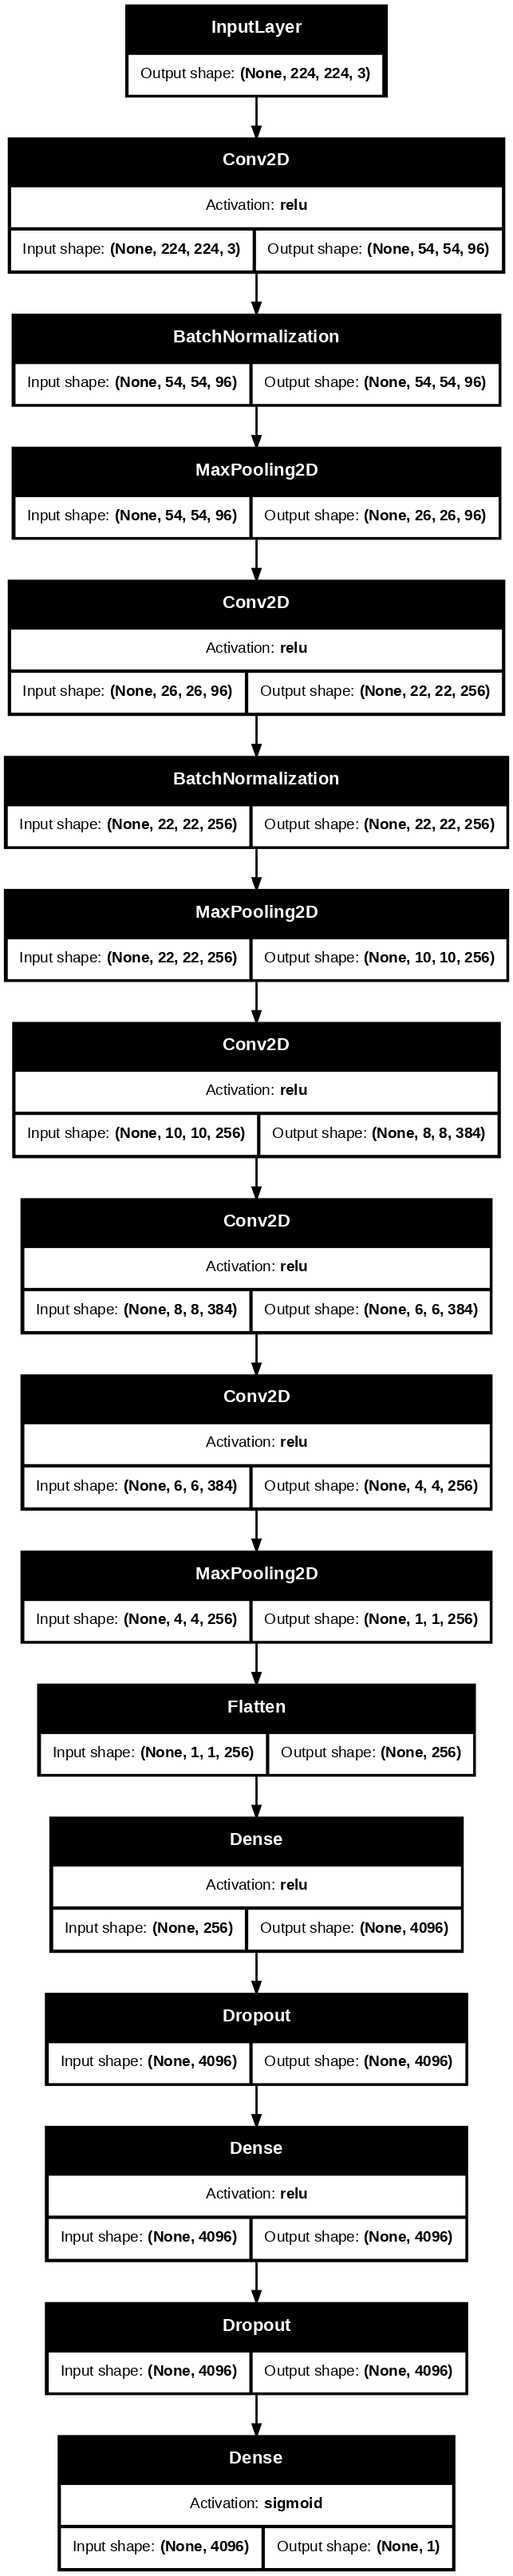

In [14]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

In [15]:
for (img, label) in train_dataset:
  print(model(img).numpy().shape, label.numpy())
  break

(4, 1) [0 0 1 1]


In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5,
                   monitor='loss')

In [18]:
model.fit(train_dataset, epochs=100, validation_data=test_dataset,
          callbacks=[es])

Epoch 1/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 94s 18ms/step - accuracy: 0.5029 - loss: 0.7819 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 2/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.5039 - loss: 0.6936 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 3/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - accuracy: 0.5019 - loss: 0.7189 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 4/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - accuracy: 0.5039 - loss: 0.6935 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 5/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.5052 - loss: 0.6932 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 6/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.5027 - loss: 0.6935 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 7/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.5065 - loss: 0.6933 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 8/100
4653/4653 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - accuracy: 

In [21]:
history = model.history

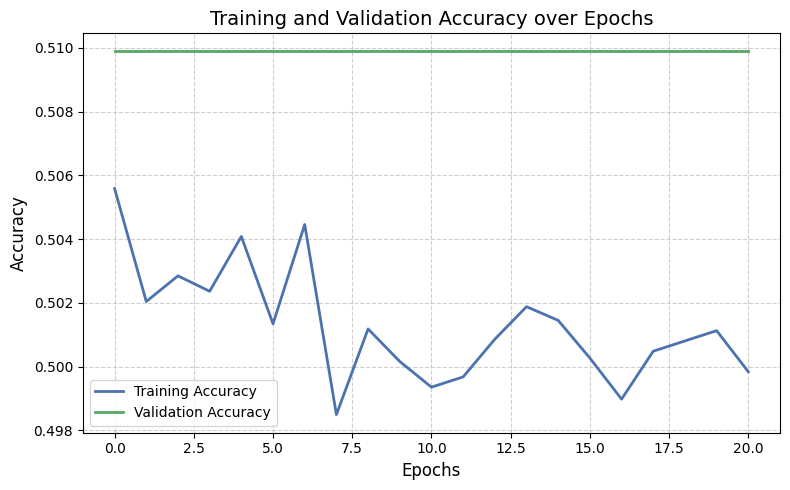

In [26]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-deep')  # modern clean style
plt.figure(figsize=(8, 5))
plt.plot(model.history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

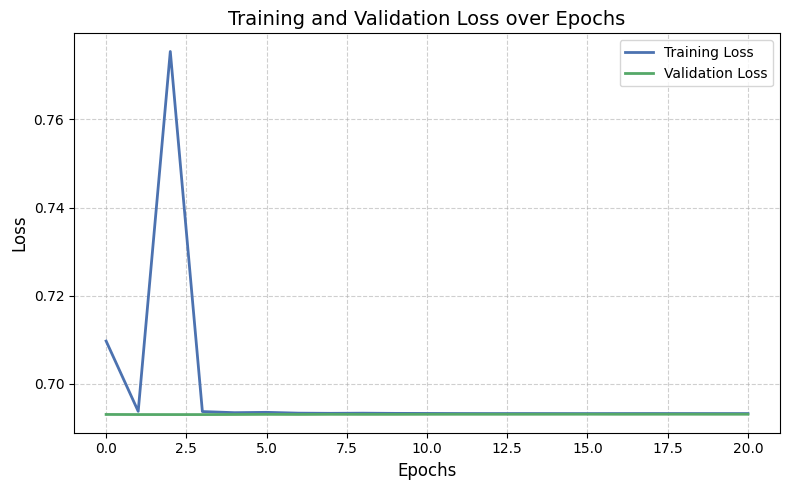

In [25]:
plt.style.use('seaborn-v0_8-deep')  # modern clean style
plt.figure(figsize=(8, 5))
plt.plot(model.history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()